# CIFAR-10 с трюками

В этом задании мы продолжим работать с CIFAR-10, опробовав трюки, про которые мы узнали в 4 модуле.

Датасет CIFAR-10 состоит из цветных картинок 32x32, разделенных на 10 классов: 

__airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__

# Импорты

In [1]:
!pip install -q tensorflow==2.1

In [2]:
from sklearn.metrics import accuracy_score
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf


# Загружаем данные

In [3]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
print("Трейн:", x_train.shape, y_train.shape)
print("Тест:", x_test.shape, y_test.shape)

Трейн: (50000, 32, 32, 3) (50000, 1)
Тест: (10000, 32, 32, 3) (10000, 1)


In [5]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

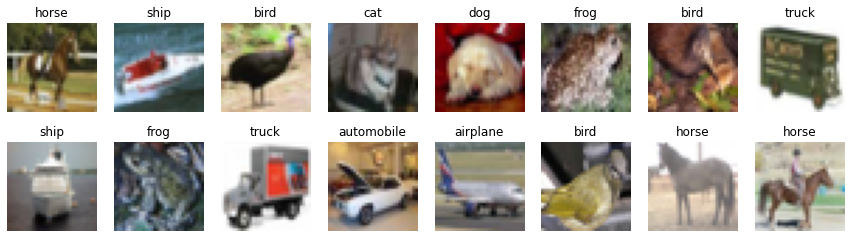

In [6]:
# посмотрим на примеры картинок
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Готовим данные

Не забудьте нормализовать картинки: $$x_{norm} = \frac{x}{255} - 0.5$$

А еще нужно превратить метки в one-hot вектора при помощи __keras.utils.to_categorical__.

In [7]:
# нормализуем входы
x_train2 = x_train.astype('float32') / 255 - 0.5
x_test2 = x_test.astype('float32') / 255 - 0.5

# конвертируем метки в np.array (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Задаем *дефолтную* архитектуру сети

In [8]:
# слои, которые нам пригодятся
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

Нам понадобятся такие слои:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - сверточный слой:
    - **filters**: количество фильтров на выходе; 
    - **kernel_size**: размер скользящего окна;
    - **padding**: padding="same" добивает нулями, чтобы ширина и высота на выходе не изменились, padding='valid' берет только окна, которые полностью помещаются в картинке;
    - **activation**: "relu", "tanh", итд;
    - **input_shape**: размер входа вида (W, H, C_in).
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - пулинг
- [Flatten](https://keras.io/layers/core/#flatten) - все оси, кроме батча (первой) вытягиваются в один вектор.
- [Dense](https://keras.io/layers/core/#dense) - плотный, активацию можно задать через activation="elu" или activation="softmax".
- [Dropout](https://keras.io/layers/core/#dropout) - дропаут регуляризация (без нее сеть сильно переобучается), позже узнаем какой у нее смысл.

Ваша модель должна принимать на вход цветную картинку __(None, 32, 32, 3)__ и предсказывать вероятности 10 классов __(None, 10)__.

Добавьте __4__ сверточных слоя с окном __(3, 3)__ с нарастающим количеством фильтров: __(16, 32, 32, 64)__, используйте "same" паддинг.

Добавьте __2x2__ макс пулинг после каждых 2 сверточных слоев (conv-conv-pool схема).

Используйте __activation='relu'__ для всех слоев, где это нужно.

Добавьте плотный слой из __256__ нейронов и еще один из __10__ нейронов для предсказания выходов. Не забудьте применить __Flatten__ перед первым плотным слоем!

Для регуляризации сети вставьте Dropout после каждого пулинг слоя (с параметром** 0.25**) и между плотными слоями на выходе (с параметром **0.5**).

В дальнейшем будем называть эту архитектуру **дефолтной** и будем исследовать небольшие изменения в ней!

In [49]:
def make_default_model(activation='relu', batch=False):
    model = Sequential()
    model.add(L.Conv2D(16, kernel_size=3, strides=1, padding='same', activation=activation, input_shape=(32, 32, 3)))
    if batch:
      model.add(BatchNormalization())
    model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same', activation=activation))
    if batch:
      model.add(BatchNormalization())    
    model.add(L.MaxPool2D())
    model.add(L.Dropout(.25))
    model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same', activation=activation))
    if batch:
      model.add(BatchNormalization())    
    model.add(L.Conv2D(64, kernel_size=3, strides=1, padding='same', activation=activation))
    if batch:
      model.add(BatchNormalization())    
    model.add(L.MaxPool2D())
    model.add(L.Dropout(.25))
    model.add(L.Flatten())
    model.add(L.Dense(256, activation='elu'))
    if batch:
      model.add(BatchNormalization())    
    model.add(L.Dropout(.5))
    model.add(L.Dense(10, activation='softmax')) # activation='softmax'
    return model

In [50]:
K.clear_session()
model = make_default_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

# Тренируем модель

In [52]:
def train_model(make_model_func=make_default_model, activation='relu', optimizer="adam", batch=False):
  BATCH_SIZE = 32
  EPOCHS = 10

  K.clear_session()
  model = make_model_func(activation=activation, batch=batch)

  model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizer,
      metrics=['accuracy']
  )

  model.fit(
      x_train2, y_train2,  # нормализованные данные
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(x_test2, y_test2),
      shuffle=False
  )
  
  return model

Давайте посмотрим, что будет с дефолтной моделью (модель = make_default_model, оптимайзер = "adam"), если ее немного поменять:


Часть 1 :
1.   Какое качество (accuracy) на валидации дает **дефолтная архитектура**?

Часть 2:
2.   Измените в дефолтной архитектуре **relu активацию на sigmoid**, какое качество на валидации получили?
3.   Измените в дефолтной архитектуре **adam оптимайзер на sgd**, какое качество на валидации получили?
4.   Добавьте к дефолтной архитектуре **батч нормализацию** после каждого сверточного слоя и после перового полносвязного (model.add(BatchNormalization())), какое качество на валидации получили?
5.   Добавьте к дефолтной архитектуре **батч нормализацию** и смените **relu активацию на sigmoid**,  какое качество на валидации получили?
  
*Рекомендуется завести свою функцию для каждого изменения архитектуры!*


In [40]:
# учим дефолтную архитектуру
model = train_model()

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 18s 364us/sample - loss: 1.3997 - accuracy: 0.4943 - val_loss: 1.0294 - val_accuracy: 0.6333
Epoch 2/10
50000/50000 [==============================] - 17s 348us/sample - loss: 1.0163 - accuracy: 0.6410 - val_loss: 0.8681 - val_accuracy: 0.6962
Epoch 3/10
50000/50000 [==============================] - 17s 334us/sample - loss: 0.8990 - accuracy: 0.6830 - val_loss: 0.8083 - val_accuracy: 0.7174
Epoch 4/10
50000/50000 [==============================] - 21s 412us/sample - loss: 0.8271 - accuracy: 0.7086 - val_loss: 0.7833 - val_accuracy: 0.7246
Epoch 5/10
50000/50000 [==============================] - 17s 344us/sample - loss: 0.7787 - accuracy: 0.7275 - val_loss: 0.7460 - val_accuracy: 0.7436
Epoch 6/10
50000/50000 [==============================] - 17s 335us/sample - loss: 0.7460 - accuracy: 0.7379 - val_loss: 0.7281 - val_accuracy: 0.7513
Epoch 7/10
50000/50000 [====================

In [41]:
predicts = model.predict_classes(x_test2)

In [42]:
print('Test Accuracy: ', accuracy_score(y_test, predicts))

Test Accuracy:  0.7513


In [43]:
predicts_train = model.predict_classes(x_train2)

In [44]:
print('Test Accuracy on Train: ', accuracy_score(y_train, predicts_train))

Test Accuracy on Train:  0.83022


In [45]:
# учим sigmoid
model = train_model(activation='sigmoid')

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 23s 453us/sample - loss: 2.3464 - accuracy: 0.0982 - val_loss: 2.3030 - val_accuracy: 0.1000
Epoch 2/10
50000/50000 [==============================] - 22s 437us/sample - loss: 2.0799 - accuracy: 0.2220 - val_loss: 1.8368 - val_accuracy: 0.3271
Epoch 3/10
50000/50000 [==============================] - 21s 411us/sample - loss: 1.8122 - accuracy: 0.3434 - val_loss: 1.6529 - val_accuracy: 0.4086
Epoch 4/10
50000/50000 [==============================] - 20s 407us/sample - loss: 1.6859 - accuracy: 0.3922 - val_loss: 1.5541 - val_accuracy: 0.4393
Epoch 5/10
50000/50000 [==============================] - 23s 470us/sample - loss: 1.5873 - accuracy: 0.4273 - val_loss: 1.4611 - val_accuracy: 0.4696
Epoch 6/10
50000/50000 [==============================] - 21s 423us/sample - loss: 1.5000 - accuracy: 0.4561 - val_loss: 1.3796 - val_accuracy: 0.5049
Epoch 7/10
50000/50000 [====================

In [46]:
predicts = model.predict_classes(x_test2)
print('Test Accuracy: ', accuracy_score(y_test, predicts))

Test Accuracy:  0.5897


In [47]:
# учим sgd
model = train_model(optimizer="sgd")
predicts = model.predict_classes(x_test2)
print('Test Accuracy: ', accuracy_score(y_test, predicts))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 17s 348us/sample - loss: 1.9319 - accuracy: 0.2960 - val_loss: 1.6037 - val_accuracy: 0.4222
Epoch 2/10
50000/50000 [==============================] - 17s 341us/sample - loss: 1.5680 - accuracy: 0.4337 - val_loss: 1.4203 - val_accuracy: 0.4883
Epoch 3/10
50000/50000 [==============================] - 17s 341us/sample - loss: 1.4197 - accuracy: 0.4919 - val_loss: 1.2922 - val_accuracy: 0.5320
Epoch 4/10
50000/50000 [==============================] - 17s 332us/sample - loss: 1.3127 - accuracy: 0.5296 - val_loss: 1.1838 - val_accuracy: 0.5727
Epoch 5/10
50000/50000 [==============================] - 16s 324us/sample - loss: 1.2249 - accuracy: 0.5624 - val_loss: 1.0941 - val_accuracy: 0.6125
Epoch 6/10
50000/50000 [==============================] - 16s 324us/sample - loss: 1.1557 - accuracy: 0.5904 - val_loss: 1.0366 - val_accuracy: 0.6368
Epoch 7/10
50000/50000 [====================

In [53]:
# батч нормализацию
model = train_model(batch=True)
predicts = model.predict_classes(x_test2)
print('Test Accuracy: ', accuracy_score(y_test, predicts))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 22s 438us/sample - loss: 1.4631 - accuracy: 0.5028 - val_loss: 1.0092 - val_accuracy: 0.6423
Epoch 2/10
50000/50000 [==============================] - 20s 401us/sample - loss: 1.0001 - accuracy: 0.6484 - val_loss: 0.8311 - val_accuracy: 0.7148
Epoch 3/10
50000/50000 [==============================] - 21s 412us/sample - loss: 0.8651 - accuracy: 0.6969 - val_loss: 0.7523 - val_accuracy: 0.7370
Epoch 4/10
50000/50000 [==============================] - 20s 398us/sample - loss: 0.7777 - accuracy: 0.7281 - val_loss: 0.7262 - val_accuracy: 0.7487
Epoch 5/10
50000/50000 [==============================] - 21s 421us/sample - loss: 0.7113 - accuracy: 0.7506 - val_loss: 0.6607 - val_accuracy: 0.7683
Epoch 6/10
50000/50000 [==============================] - 21s 417us/sample - loss: 0.6536 - accuracy: 0.7718 - val_loss: 0.6415 - val_accuracy: 0.7826
Epoch 7/10
50000/50000 [====================

In [54]:
model = train_model(activation='sigmoid', batch=True)
predicts = model.predict_classes(x_test2)
print('Test Accuracy: ', accuracy_score(y_test, predicts))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 20s 408us/sample - loss: 1.4722 - accuracy: 0.4938 - val_loss: 1.1402 - val_accuracy: 0.6168
Epoch 2/10
50000/50000 [==============================] - 19s 384us/sample - loss: 1.0741 - accuracy: 0.6229 - val_loss: 1.0504 - val_accuracy: 0.6510
Epoch 3/10
50000/50000 [==============================] - 19s 388us/sample - loss: 0.9692 - accuracy: 0.6597 - val_loss: 0.8652 - val_accuracy: 0.7036
Epoch 4/10
50000/50000 [==============================] - 19s 379us/sample - loss: 0.8906 - accuracy: 0.6884 - val_loss: 1.0281 - val_accuracy: 0.6446
Epoch 5/10
50000/50000 [==============================] - 19s 380us/sample - loss: 0.8218 - accuracy: 0.7132 - val_loss: 0.8176 - val_accuracy: 0.7124
Epoch 6/10
50000/50000 [==============================] - 19s 378us/sample - loss: 0.7679 - accuracy: 0.7321 - val_loss: 0.7567 - val_accuracy: 0.7377
Epoch 7/10
50000/50000 [====================